In [1]:
#miRNA enrichment analysis per each supercluster
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
plt.rcParams['svg.fonttype'] = 'none'

mirna_edges = pd.read_csv("mirna_edges.csv")
mirna_clusters = pd.read_csv("miR_superclustering.csv")
mirna_corr = mirna_edges[(mirna_edges["correlation"] < -0.7)
                         & (mirna_edges["score"] > 100)]

In [2]:
# here the Top5 mirnas are determined

superclusters = mirna_clusters[[
    "cluster", "hierachical_cluster"
]].drop_duplicates()  # cluster from expression dataset
mirna_expression = mirna_corr[[
    "mirna", "baseMean", "cluster_mirna"
]].drop_duplicates()  # cluster from miRNA_edges dataset
mirna_top5 = pd.DataFrame()  # determine the top5
for i in set(
        mirna_expression["cluster_mirna"]
):  # loop to determine top 5 by individiually selecting the mirna modules
    mirna_exp = mirna_expression[mirna_expression["cluster_mirna"] == i]
    mirna_exp = mirna_exp.sort_values("baseMean", ascending=False).iloc[:5, :]
    mirna_top5 = mirna_top5.append(mirna_exp)
mirna_top5.to_csv("Top_miRNAs_module.csv")

In [3]:
def mirna_analysis_go_div(diana_df, species):
    # diana_dictionary == output von diana_only mirnas bzw. eigener DataFrame,
    # col_name is der Name der Column, die die Gene beinhaltet
    # sources = sind die sources die man gerne erhalten möchte als Liste bspw. ["GO"] wären alle Termen
    # ["GO:BP"] wäre einzig und allein Biological Process
    # KEGG ist ein optionaler parameter der angegeben kann wenn man auch an KEGG Pathways interessiert ist
    go_profiler = {}
    df_go_end = pd.DataFrame()
    protein_list = diana_df
    print(len(protein_list))

    r = requests.post(url='https://biit.cs.ut.ee/gprofiler/api/gost/profile/',
                      json={
                          'organism': species,
                          'query': protein_list,
                          'sources': ["GO:BP", "GO:MF", "GO:CC", "KEGG"],
                      },
                      headers={'User-Agent': 'FullPythonRequest'})
    try:
        data = r.json()["result"]
        parents_list = []
        go_list = []
        p_value = []
        desc_value = []
        source_list = []
        for n in data:
            go_list.append(n["native"])
            for t in n["parents"]:
                parents_list.append(t)
        end_list = [i for i in go_list if i not in parents_list]
        for m in data:
            if m["native"] in end_list:
                p_value.append(m["p_value"])
        for l in data:
            if l["native"] in end_list:
                desc_value.append(l["name"])
        for l in data:
            if l["native"] in end_list:
                source_list.append(l["source"])
        go_profiler.update({
            "p-value": p_value,
            "go-terms": end_list,
            "description": desc_value,
            "source": source_list
        })
        df_go = pd.DataFrame(
            columns=["go-terms", "description", "source", "p-value"])
        df_go["go-terms"] = list(end_list)
        df_go["description"] = desc_value
        df_go["source"] = source_list
        df_go["p-value"] = p_value

    except KeyError as e:
        pass

    #df_go_end.to_excel("signed_go_enrichment_analysis_filtered.xlsx")
    return (df_go)

In [4]:
mirna_cenr = pd.DataFrame()
top_mirna_enr = pd.DataFrame()
genes_mirna = pd.DataFrame()
for mirna in set(mirna_clusters["cluster"]):
    genes_dataframe = pd.DataFrame()  # new dataframe to get genes
    mirna_liste = mirna_clusters[mirna_clusters["cluster"] == mirna][
        "Row.names"]  # slice the dataframe for each cluster
    genes_liste = list(
        set(mirna_corr[mirna_corr["mirna"].isin(mirna_liste)]["gene_name"].
            tolist()))  # get the set of genes -> avoid duplicates

    # get the genes per cluster
    genes_dataframe["genes"] = genes_liste
    genes_dataframe["cluster"] = genes_dataframe.shape[0] * [
        str(mirna)
    ]  # assign the queried cluster to the new table
    # get the reverse enrichments for each cluster
    genes_enrichment = mirna_analysis_go_div(genes_liste, "hsapiens")
    genes_enrichment["cluster"] = genes_enrichment.shape[0] * [
        str(mirna)
    ]  # assign the queried cluster to the new table
    genes_enrichment_top = genes_enrichment.sort_values("p-value").iloc[:10, :]
    # append the tables with the new data
    top_mirna_enr = top_mirna_enr.append(genes_enrichment_top)
    mirna_cenr = mirna_cenr.append(genes_enrichment)
    genes_mirna = genes_mirna.append(genes_dataframe)

44
576
440
238
110
136
45
467
366
560
285
496
39
444
740
188
289


In [8]:
# try to groupby the table by clusters and descriptions
import numpy as np
import networkx as nx

# get the targeted miRNAs genes supercluster
genes_mirna = pd.merge(genes_mirna,
                       superclusters,
                       how="left",
                       left_on="cluster",
                       right_on="cluster")
genes_mirna.to_csv("mirna_targeting_cluster.csv")

# p-value log10p normalization for visualization purposes
top_mirna_enr["log10p"] = top_mirna_enr["p-value"].apply(
    lambda x: -(np.log10(x)))

top_mirna_enr = pd.merge(top_mirna_enr,
                         superclusters,
                         how="left",
                         left_on="cluster",
                         right_on="cluster")

       go-terms                                       description source  \
0    GO:0070937               CRD-mediated mRNA stability complex  GO:CC   
1    GO:1990180              mitochondrial tRNA 3'-end processing  GO:BP   
2    GO:0030426                                       growth cone  GO:CC   
3    GO:0007411                                     axon guidance  GO:BP   
4    GO:0048522           positive regulation of cellular process  GO:BP   
..          ...                                               ...    ...   
127  GO:0003924                                   GTPase activity  GO:MF   
128  GO:0098563  intrinsic component of synaptic vesicle membrane  GO:CC   
129  GO:0032870             cellular response to hormone stimulus  GO:BP   
130  KEGG:05163                   Human cytomegalovirus infection   KEGG   
131  GO:0016055                             Wnt signaling pathway  GO:BP   

      p-value    cluster    log10p  hierachical_cluster  
0    0.016723     salmon  1.7

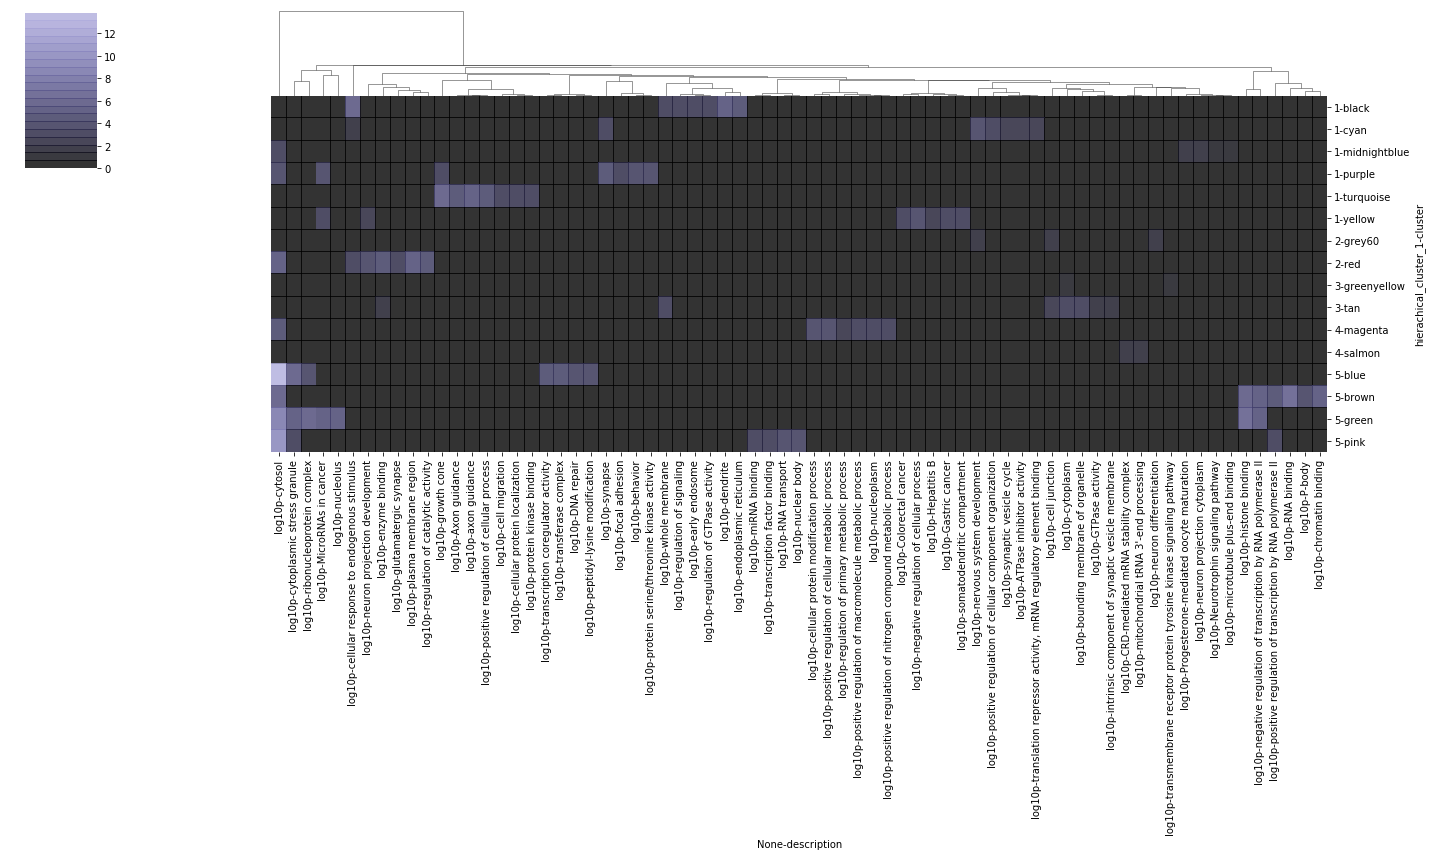

In [9]:
# enrichmetn heatmaps based on negative log10p for each of the modules
def heatmap(top_mirna):
    cluster_end = {
        3: 1,
        4: 2,
        5: 3,
        2: 4,
        1: 5
    }  # make a ranking from early stage --> late stage
    print(top_mirna)
    top_mirna["hierachical_cluster_1"] = [
        cluster_end.get(i) for i in top_mirna["hierachical_cluster"]
    ]

    top_enr = top_mirna.sort_values(["hierachical_cluster_1", "cluster"],
                                    ascending=False)
    top_enr = top_enr.set_index("description")
    grouped_enr = pd.DataFrame(
        top_enr.groupby(["hierachical_cluster_1",
                         "cluster"])["log10p"].nlargest(7))
    trial = grouped_enr.unstack()
    trial = trial.fillna(0)
    sns.clustermap(trial,
                   row_cluster=False,
                   col_cluster=True,
                   figsize=(20, 12),
                   cmap=sns.cubehelix_palette(20,
                                              start=9,
                                              rot=0,
                                              dark=0,
                                              light=.7,
                                              reverse=True),
                   alpha=0.8)
    """plt.savefig("cluster_map_mirna_enrichments.svg",
                quality=90,
                dpi=600,
                transparent=True)"""


heatmap(top_mirna_enr)